Calculate the integrated gradients of each group base on the models
Will allow to print the sequences or export them gradients 

In [ ]:
!pip install concise

In [18]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [19]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [20]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import glob
import sys

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.use('Agg')
%matplotlib inline

import utils
sys.path.append(".")
import plotseqlogo
import IntegratedGradients
from plotseqlogo import *
from IntegratedGradients import *
from utils import *
from interpretation_exp import *

from tensorflow.python.keras.backend import set_session

CLASS_RESISTANT = 0
CLASS_PRONE = 1 

In [21]:
def get_refrence_mean_baseline(current_seq,mean_sequence):
  """
  Get a refrence sequence based on the mean sequences 
  :param: current_seq - The current sequence we are trying to create baseline to
  :param: mean_sequence - The mean value of all sequences
  """
  baseline = current_seq * mean_sequence 
  return baseline


def get_explanations(models, predict_label, rf_mean_sequence, x_sequences, y_labels, number_of_sequences_to_explain=-1, threshold =0.5):
  """
  Get explanations in format of integreated gradients for the different sequences
  :param models: The models to use to get the explanations
  :param predict_label: The label we should predict
  :param rf_mean_sequence: The refrence sequence based on mean of all sequences
  :param x_sequences: x dataset to explain
  :param y_labels: The labels of the dataset
  :param number_of_sequences_to_explain: Number of sequences to explain, -1 mean all
  :param threshold : threshold of prediction to consider this a good sequence 
  :return: The explanation using integrated gradients 
  """
  
  # Need to see if we can do without this 
  # sess = tf.Session()
  # tf.random.set_random_seed(5005)
  # K.set_session(sess)

  # session = K.get_session()
  init = tf.global_variables_initializer()
  # session.run(init)

  true_prediction_index= []
  # with session.as_default():
  #     with session:
  print("predicting")
  model_pred = predict(models, x_sequences)

  model_pred = 1 - model_pred if predict_label ==CLASS_RESISTANT else model_pred

  print("getting sequences")
  for i in sorted(enumerate(model_pred), key=lambda x:x[1],reverse=True):
    if y_labels[i[0]]==predict_label and model_pred[i[0]] > threshold :
      true_prediction_index.append(i[0])
  
  if number_of_sequences_to_explain != -1:
    true_prediction_index = true_prediction_index[:number_of_sequences_to_explain]

  print("getting explanation")
  explanations = []
  for model in models:
    gradients = integrated_gradients(model) 
    model_explanation=np.array([gradients.explain([x_sequences[i]],reference=[get_refrence_mean_baseline(x_sequences[i], rf_mean_sequence)],num_steps=100)[0] for i in true_prediction_index])
    explanations.append(model_explanation)

  combined_explanation = np.array(explanations).mean(axis=0)

  if predict_label == CLASS_RESISTANT:
    combined_explanation = combined_explanation * -1

  return combined_explanation

In [22]:
def get_explanation_for_data(models_folder, data_path, save_path=None, number_of_seq=-1, threshold=0.5,title="zhou"):
  """
  Get an explanation in form of integrated gradients for all the test data in data_path using the models 
  :param: models_folder - The path for with all the models 
  :param: data_path - The path of the dataset
  :param: save_path - should we save the gradients to a dictionary for later use 
  """
  # Upload the data and create the refrence sequence based on the mean of all validation and training data
  print("Loading data")
  _,_,_,_, x_test_seq, y_test, x_train, _ = load_train_validate_test_data(data_path, 150, False)
  mean_sequence = x_train.mean(axis=0)

  # Load the models 
  models_paths = glob.glob(os.path.join(models_folder, "*"))
  models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  print("Calculating gradients")
  cl_gradients = get_explanations(models, predict_label=CLASS_PRONE, number_of_sequences_to_explain=number_of_seq, threshold=threshold, rf_mean_sequence=mean_sequence, x_sequences=x_test_seq, y_labels=y_test)
  pl_gradients = get_explanations(models, predict_label=CLASS_RESISTANT, number_of_sequences_to_explain=number_of_seq, threshold=threshold, rf_mean_sequence=mean_sequence, x_sequences=x_test_seq, y_labels=y_test)

  if save_path:
    gradients_dictionary = {"hypo-prone": cl_gradients, "hypo-resistant": pl_gradients}

    with open("./gradients_explain/all/graidnets_dictionary_%s.pkl" %title, "wb") as f:
      pickle.dump(gradients_dictionary, f)

  return cl_gradients, pl_gradients

Get the explanations 

In [ ]:
zhou_models_folder="./models/folds_models/covariance/5-folds"
sc_models_folder="./models/folds_models/sc/5-folds"

scgwbs_data = r"dataset/scwgbs_crc01_dataset/scwgbs1_crc01.pkl"
zhou_all_data = r"dataset/covariance/bulk_prone_0.0153/bulk.pkl"


cl_gradients, pl_gradients = get_explanation_for_data(zhou_models_folder, zhou_all_data, threshold=0.8, save_path=True, title="zhou")
_, _ = get_explanation_for_data(zhou_models_folder, zhou_all_data, threshold=0.8, save=True, title="bian")
gradients_dictionary = {"hypo-prone": cl_gradients, "hypo-resistant": pl_gradients}

#Parse interpretation 

In [136]:
with open("./gradients_explain/all/graidnets_dictionary_zhou.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

# Fixing naming
try:
  temp = gradients_dictionary
  gradients_dictionary = {"hypo-prone":temp["cl"], "hypo-resistant":temp["pl"]}
except:
  gradients_dictionary = temp

In [ ]:
# Save the gradients and sequences to csv 
a = gradients_dictionary["hypo-resistant"].sum(axis=2)
np.savetxt("zhou_resist_gradients.csv", a, delimiter=",")

a = gradients_dictionary["hypo-prone"].sum(axis=2)
np.savetxt("zhou_prone_gradients.csv", a, delimiter=",")

a = gradients_dictionary["hypo-prone"] !=0
temp = np.zeros_like(a).astype(np.int)
temp[np.all(a==np.array([1,0,0,0]), axis=2)] = np.array([1,0,0,0])
temp[np.all(a==np.array([0,1,0,0]), axis=2)] = np.array([2,0,0,0])
temp[np.all(a==np.array([0,0,1,0]), axis=2)] = np.array([3,0,0,0])
temp[np.all(a==np.array([0,0,0,1]), axis=2)] = np.array([4,0,0,0])
temp = temp.sum(axis=2)
np.savetxt("zhou_prone_seq.csv", temp, delimiter=",")

a = gradients_dictionary["hypo-resistant"] !=0
temp = np.zeros_like(a).astype(np.int)
temp[np.all(a==np.array([1,0,0,0]), axis=2)] = np.array([1,0,0,0])
temp[np.all(a==np.array([0,1,0,0]), axis=2)] = np.array([2,0,0,0])
temp[np.all(a==np.array([0,0,1,0]), axis=2)] = np.array([3,0,0,0])
temp[np.all(a==np.array([0,0,0,1]), axis=2)] = np.array([4,0,0,0])
temp = temp.sum(axis=2)
np.savetxt("zhou_resistant_seq.csv", temp, delimiter=",")

In [ ]:
with open("./gradients_explain/all/graidnets_dictionary_bian.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

# Fixing naming
try:
  temp = gradients_dictionary
  gradients_dictionary = {"hypo-prone":temp["cl"], "hypo-resistant":temp["pl"]}
except:
  gradients_dictionary = temp

/gdrive/My Drive/nn/plotseqlogo.py:180: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


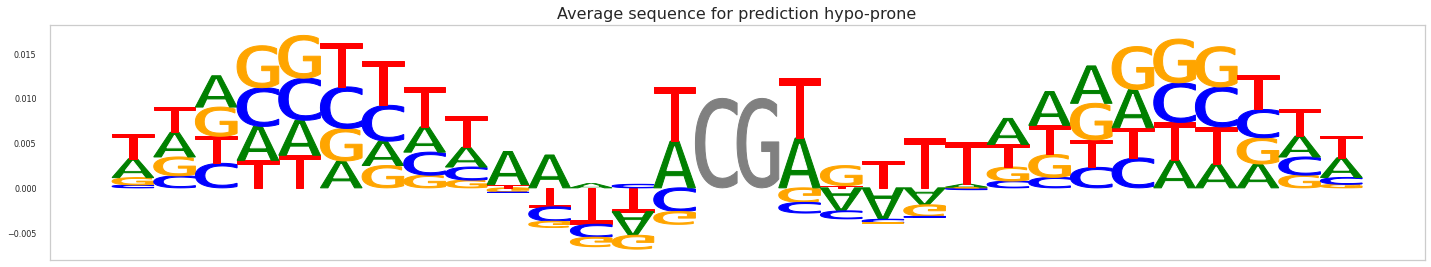

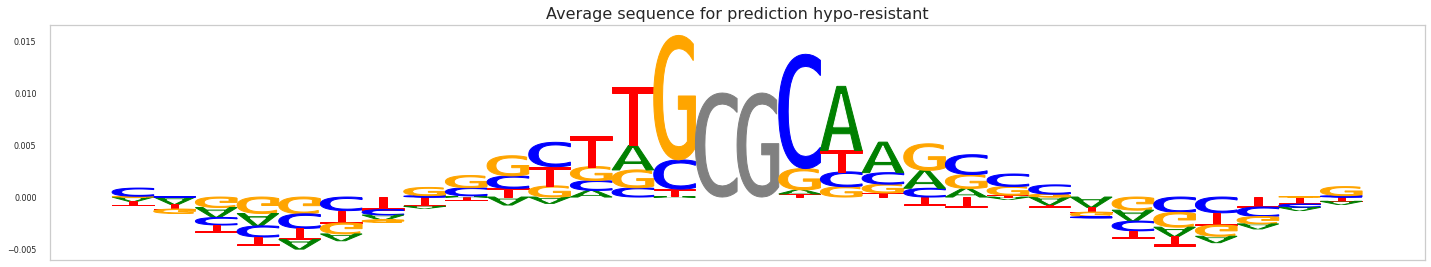

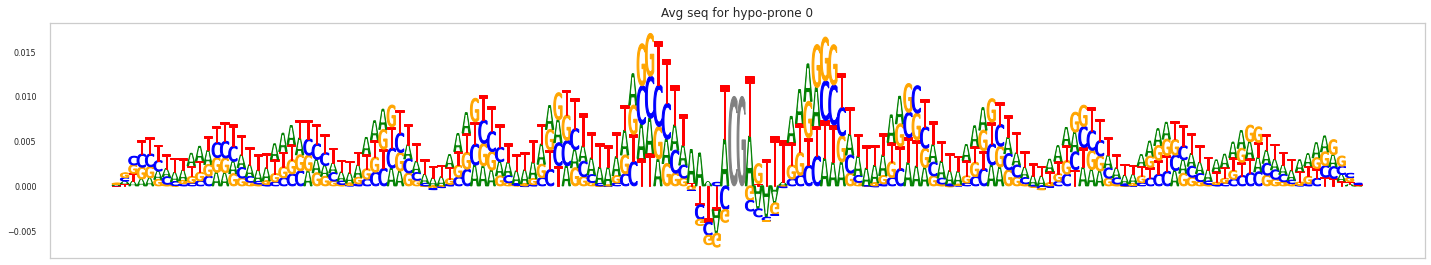

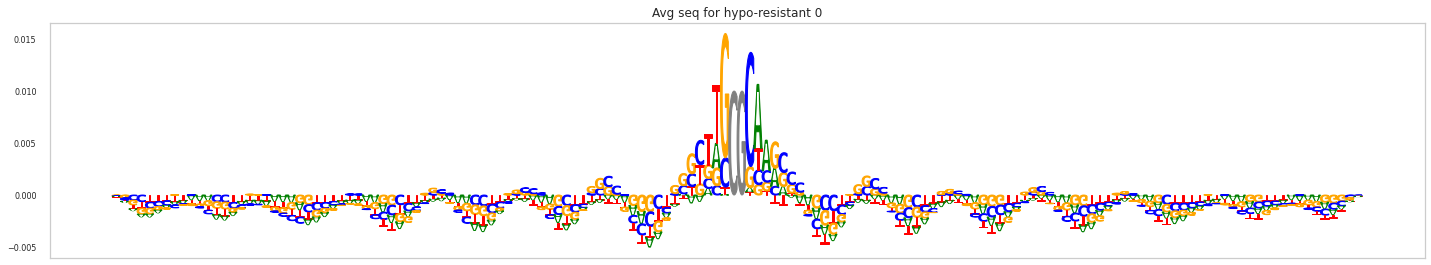

In [ ]:
plot_avg_sequence(gradients_dictionary)

In [ ]:
# Save the gradients and sequences to csv 
a = gradients_dictionary["hypo-resistant"].sum(axis=2)
np.savetxt("bian_resist_gradients.csv", a, delimiter=",")

a = gradients_dictionary["hypo-prone"].sum(axis=2)
np.savetxt("bian_prone_gradients.csv", a, delimiter=",")

a = gradients_dictionary["hypo-prone"] !=0
temp = np.zeros_like(a).astype(np.int)
temp[np.all(a==np.array([1,0,0,0]), axis=2)] = np.array([1,0,0,0])
temp[np.all(a==np.array([0,1,0,0]), axis=2)] = np.array([2,0,0,0])
temp[np.all(a==np.array([0,0,1,0]), axis=2)] = np.array([3,0,0,0])
temp[np.all(a==np.array([0,0,0,1]), axis=2)] = np.array([4,0,0,0])
temp = temp.sum(axis=2)
np.savetxt("bian_prone_seq.csv", temp, delimiter=",")

a = gradients_dictionary["hypo-resistant"] !=0
temp = np.zeros_like(a).astype(np.int)
temp[np.all(a==np.array([1,0,0,0]), axis=2)] = np.array([1,0,0,0])
temp[np.all(a==np.array([0,1,0,0]), axis=2)] = np.array([2,0,0,0])
temp[np.all(a==np.array([0,0,1,0]), axis=2)] = np.array([3,0,0,0])
temp[np.all(a==np.array([0,0,0,1]), axis=2)] = np.array([4,0,0,0])
temp = temp.sum(axis=2)
np.savetxt("bian_resistant_seq.csv", temp, delimiter=",")

In [ ]:
# Plot images 

def seqlogo(letter_heights, vocab="DNA", ax=None, yl=None):
    """Make a logo plot
    # Arguments
        letter_heights: "motif length" x "vocabulary size" numpy array
    Can also contain negative values.
        vocab: str, Vocabulary name. Can be: DNA, RNA, AA, RNAStruct.
        ax: matplotlib axis
    """
    ax = ax or plt.gca()

    assert letter_heights.shape[1] == len(VOCABS[vocab])
    x_range = [1, letter_heights.shape[0]]
    pos_heights = np.copy(letter_heights)
    pos_heights[letter_heights < 0] = 0
    neg_heights = np.copy(letter_heights)
    neg_heights[letter_heights > 0] = 0

    for x_pos, heights in enumerate(letter_heights):
        letters_and_heights = sorted(zip(heights, list(VOCABS[vocab].keys())))
        y_pos_pos = 0.0
        y_neg_pos = 0.0
        for height, letter in letters_and_heights:
            color = VOCABS[vocab][letter]
            polygons = letter_polygons[letter]
            if height > 0:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_pos_pos, height)
                y_pos_pos += height
            elif height == 0 and ((x_pos == len(letter_heights) / 2 and letter == 'G') or (
                    x_pos == len(letter_heights) / 2 - 1 and letter == 'C')):
                height =0.01
                add_letter_to_axis(ax, polygons, "gray", 0.5 + x_pos, y_pos_pos, height)
                y_pos_pos += height
            elif height == 0:
                pass
            else:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_neg_pos, height)
                y_neg_pos += height

    # if add_hline:
    #     ax.axhline(color="black", linewidth=1)
    # ax.set_xlim(x_range[0] - 1, x_range[1] + 1)

    if yl:
        ax.set_ylim(-yl, yl)


    ax.grid(False)
    # ax.set_xticks(list(range(*x_range)) + [x_range[-1]])
    ax.set_xticks([], [])
    ax.yaxis.set_tick_params(labelsize=8)
    ax.set_aspect(aspect='auto', adjustable='box')
    ax.autoscale_view()



def seqlogo_fig(letter_heights, vocab="DNA", figsize=(10, 2), ncol=1, plot_name=None, yl=None):
    """
    # Arguments
        plot_name: Title of the plot. Can be a list of names
    """
    fig = plt.figure(figsize=figsize)

    if len(letter_heights.shape) == 3:
        #
        n_plots = letter_heights.shape[2]
        nrow = math.ceil(n_plots / ncol)
        if isinstance(plot_name, list):
            assert len(plot_name) == n_plots
    else:
        n_plots = 1
        nrow = 1
        ncol = 1

    for i in range(n_plots):
        if len(letter_heights.shape) == 3:
            w_cur = letter_heights[:, :, i]
        else:
            w_cur = letter_heights
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.tight_layout(h_pad=0.1)

        # plot the motif
        seqlogo(w_cur, vocab, ax, yl)

        # add the title
        if plot_name is not None:
            if n_plots > 0:
                if isinstance(plot_name, list):
                    pln = plot_name[i]
                else:
                    pln = plot_name + " {0}".format(i)
            else:
                pln = plot_name
            ax.set_title(pln)
    return fig


with open("./gradients_explain/all/graidnets_dictionary_bian.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

# Fixing naming
try:
  temp = gradients_dictionary
  gradients_dictionary = {"hypo-prone":temp["cl"], "hypo-resistant":temp["pl"]}
except:
  gradients_dictionary = temp


prone = []
resist = []

# Remove duplicates
seq = None

for i in range(gradients_dictionary["hypo-resistant"].shape[0]):
  new_seq = gradients_dictionary["hypo-resistant"][i]
  if np.all(new_seq == seq):
      continue
  else:
      resist.append(new_seq)
      seq = new_seq

seq = None
for i in range(gradients_dictionary["hypo-prone"].shape[0]):
  new_seq = gradients_dictionary["hypo-prone"][i]
  if np.all(new_seq == seq):
      continue
  else:
      prone.append(new_seq)
      seq = new_seq

import tqdm

for i in tqdm.trange(200):
  fig = seqlogo_fig(resist[i], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-resistant %s" %i)
  fig.savefig("./gradients_explain/all/bian_sequences/hypo-resistant/%s.png" %i)
  plt.close()

  fig = seqlogo_fig(prone[i], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-prone %s" %i)
  fig.savefig("./gradients_explain/all/bian_sequences/hypo-prone/%s.png" %i)
  plt.close()


/gdrive/My Drive/nn/plotseqlogo.py:180: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


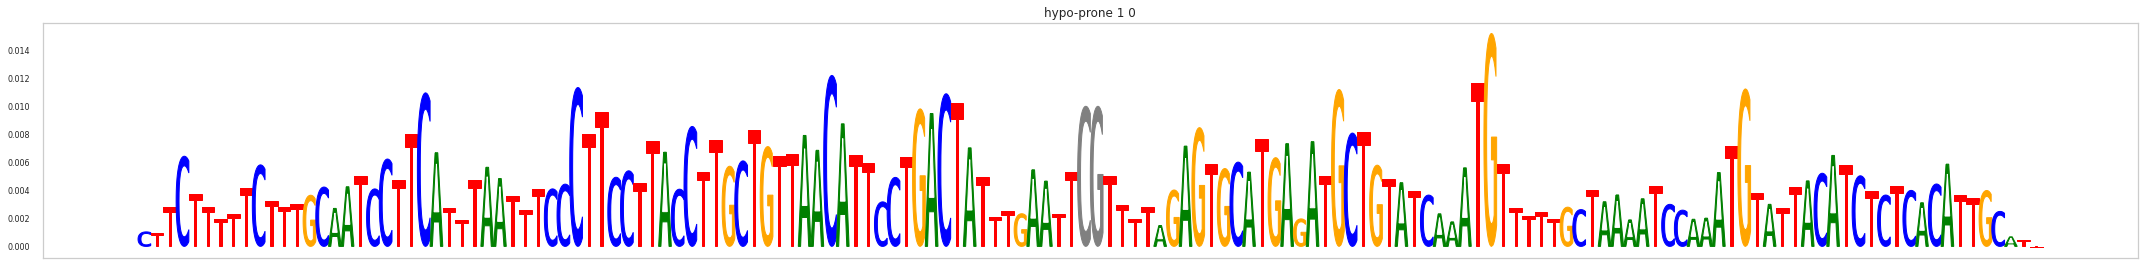

In [ ]:
fig = seqlogo_fig(cl_gradients[0], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-prone %s" %1)